# Anomaly Detection Autoencoders with Noise Injection



In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np 
import cv2 
import os 
import gc
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing import image
# from matplotlib import image

In [3]:
img = image.load_img("/home/sauraj/Desktop/MVTec/bottle/test/contamination/000.png")

## Step 1: Loading the Images 

In [2]:
from skimage.io import imread, imshow
from skimage.transform import resize

PATH = r"/home/sauraj/Desktop/MVTec/screw/train/good/"
TEST_PATH = r"/home/sauraj/Desktop/MVTec/screw/test/"
GROUND_TRUTH = r"/home/sauraj/Desktop/MVTec/screw/ground_truth/"

train_ids = next(os.walk(PATH))[2]

# TEST_PATH = PATH+'test/'
test_folders = next(os.walk(TEST_PATH))[1]

MASK_PATH = PATH+'ground_truth/'
mask_folders = test_folders.copy()
mask_folders.remove('good')

X_color, y_bad_color, y_good_color, mask = [],[],[],[]

# for id in train_ids:
#     path = PATH + id
#     print(path)

for id in train_ids:
    path = PATH + id
    img = imread(path)
    img = resize(img, (256,256), mode='constant', preserve_range=True)
    X_color.append(img)

for folder in test_folders:
    folder_path = TEST_PATH+folder
    for id in sorted(next(os.walk(folder_path))[2]):
        img = imread(folder_path+'/'+id)
        img = resize(img, (256,256), mode='constant', preserve_range=True)
        if folder == 'good':
            y_good_color.append(img)
        else:
            y_bad_color.append(img)

for folder in mask_folders:
    folder_path = GROUND_TRUTH+folder
    for id in sorted(next(os.walk(folder_path))[2]):
        img = imread(folder_path+'/'+id)
        img = resize(img, (256, 256), mode='constant', preserve_range=True)
        mask.append(img)

X_color = np.asarray(X_color)
y_good_color = np.asarray(y_good_color)
y_bad_color = np.asarray(y_bad_color)
mask = np.asarray(mask)

gc.collect()
print("Training data Sanity check: ", np.shape(X_color))
print("Normal testing data Sanity check: ",np.shape(y_good_color))
print("Anomalous testing data Sanity check: ",np.shape(y_bad_color))
print("Anomaly masks for testing Sanity check: ",np.shape(mask))

Training data Sanity check:  (320, 256, 256)
Normal testing data Sanity check:  (41, 256, 256)
Anomalous testing data Sanity check:  (119, 256, 256)
Anomaly masks for testing Sanity check:  (119, 256, 256)


In [4]:
gc.collect()

0

In [11]:
from PIL import Image 
import glob
PATH = r"/home/sauraj/Desktop/MVTec/bottle/train/**/*.*"
TEST_PATH = r"/home/sauraj/Desktop/MVTec/bottle/test/**/*.*"
GROUND_TRUTH = r"/home/sauraj/Desktop/MVTec/bottle/ground_truth/**/*.*"

# datagen = ImageDataGenerator()
# train_data = datagen.flow_from_directory(PATH, class_mode='binary')

def img_to_np(path, resize=True):
    images = []
    fpaths = glob.glob(path, recursive=True)
    for fname in fpaths: 
        img = Image.open(fname).convert("RGB")
        if(resize): img = img.resize((256,256))
        images.append(np.asarray(img))
    images = np.array(images)
    return images

def grayscale_maker(image):
    gray_img = np.zeros(image.shape)
    for i in range(len(image)):
        gray_img[i] = cv2.cvtColor(image[i], cv2.COLOR_BGR2GRAY)
    gray_img = gray_img[:,:,:,np.newaxis]
    return gray_img

In [13]:
#Loading in the images
data = img_to_np(PATH)
data_test = img_to_np(TEST_PATH)
ground_truth = img_to_np(GROUND_TRUTH)

KeyboardInterrupt: 

In [4]:
#Making them grayscale
X = grayscale_maker(X_color)
y_good = grayscale_maker(y_good_color)
y_bad = grayscale_maker(y_bad_color)

NameError: name 'grayscale_maker' is not defined

In [3]:
#Normalization by 255 
X = X_color.astype('float32') / 255.0
y_good = y_good_color.astype('float32') / 255.0
y_bad = y_bad_color.astype('float32') / 255.0

Processed image


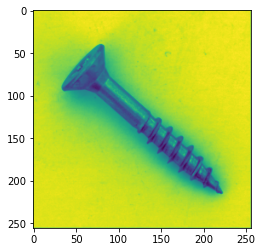

In [10]:
plt.imshow(y_good[0])
print("Processed image")

In [5]:
X = X.reshape(320, 256, 256, 1)

In [6]:
y_good = y_good.reshape(41, 256, 256, 1)

In [7]:
y_bad = y_bad.reshape(119, 256, 256, 1)

### Noise-Injected Convolutional Autoencoder

## Adding additive noise 

* Add crafted noise to the images to make the training phase for autoencoders more challenging 


In [5]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.001
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.003
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1
      # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy



In [8]:
#Random noise injection 
import random 
def random_noise_injection(images):
    #Find the 10% proportion of the total image count 
#     noise_types = ["gauss","poisson","speckle","s&p"]/
    proportion_ten = np.round(len(images) * 0.1)
    random_images = np.random.randint(0, len(images), int(proportion_ten))
    for i in range(len(images)):
        if i in random_images:
#             random_noise_type = random.choice(noise_types)
            images[i] = noisy("gauss", images[i])
            print("Noise injection of type {} done for image index {}".format(
                "gaussian", i))
    return images

In [9]:
X_injected = random_noise_injection(X)

Noise injection of type gaussian done for image index 9
Noise injection of type gaussian done for image index 11
Noise injection of type gaussian done for image index 37
Noise injection of type gaussian done for image index 40
Noise injection of type gaussian done for image index 61
Noise injection of type gaussian done for image index 75
Noise injection of type gaussian done for image index 77
Noise injection of type gaussian done for image index 81
Noise injection of type gaussian done for image index 103
Noise injection of type gaussian done for image index 117
Noise injection of type gaussian done for image index 134
Noise injection of type gaussian done for image index 137
Noise injection of type gaussian done for image index 140
Noise injection of type gaussian done for image index 144
Noise injection of type gaussian done for image index 150
Noise injection of type gaussian done for image index 153
Noise injection of type gaussian done for image index 158
Noise injection of type

### Developing the architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose,\
UpSampling2D, Dense, Reshape, InputLayer, Input, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import alibi_detect
from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.ad import AdversarialAE 
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image, plot_feature_outlier_tabular

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Lambda, Conv2D, Conv2DTranspose,\
UpSampling2D, Dense, Reshape, InputLayer, Input, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from tensorflow.keras import Model


adam = Adam(lr=0.001)

#Encoder net
input_image = Input(shape=(X.shape[1:]), name='encoder_input')
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_image)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(4, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
encoder = Dense(512, activation='relu')(x)

#Decoder net
x = Conv2D(4, (3,3), activation='relu', padding='same')(encoder)
x = UpSampling2D((2,2))(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoder = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

#Fault Tolerance checks 
callbacks = [
    EarlyStopping(patience = 5, monitor = 'val_loss')]

autoencoder = Model(input_image, decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

history = autoencoder.fit(X, X, epochs=20, validation_split=0.05, batch_size=20,
                         callbacks=callbacks)


Epoch 1/20


In [17]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 256, 256, 128)     3584      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 64)      73792     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 16)        9232      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 16)        0     

In [8]:
X[0].shape

(256, 256, 3)

In [9]:
preds_ygood = autoencoder.predict(y_good)
preds_ybad = autoencoder.predict(y_bad)

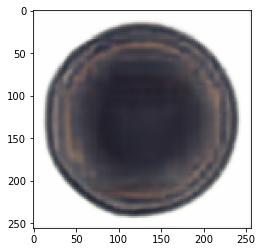

In [10]:
plt.imshow(preds_ybad[3])
# plt.savefig('/home/sauraj/Desktop/representation.png',dpi=500)

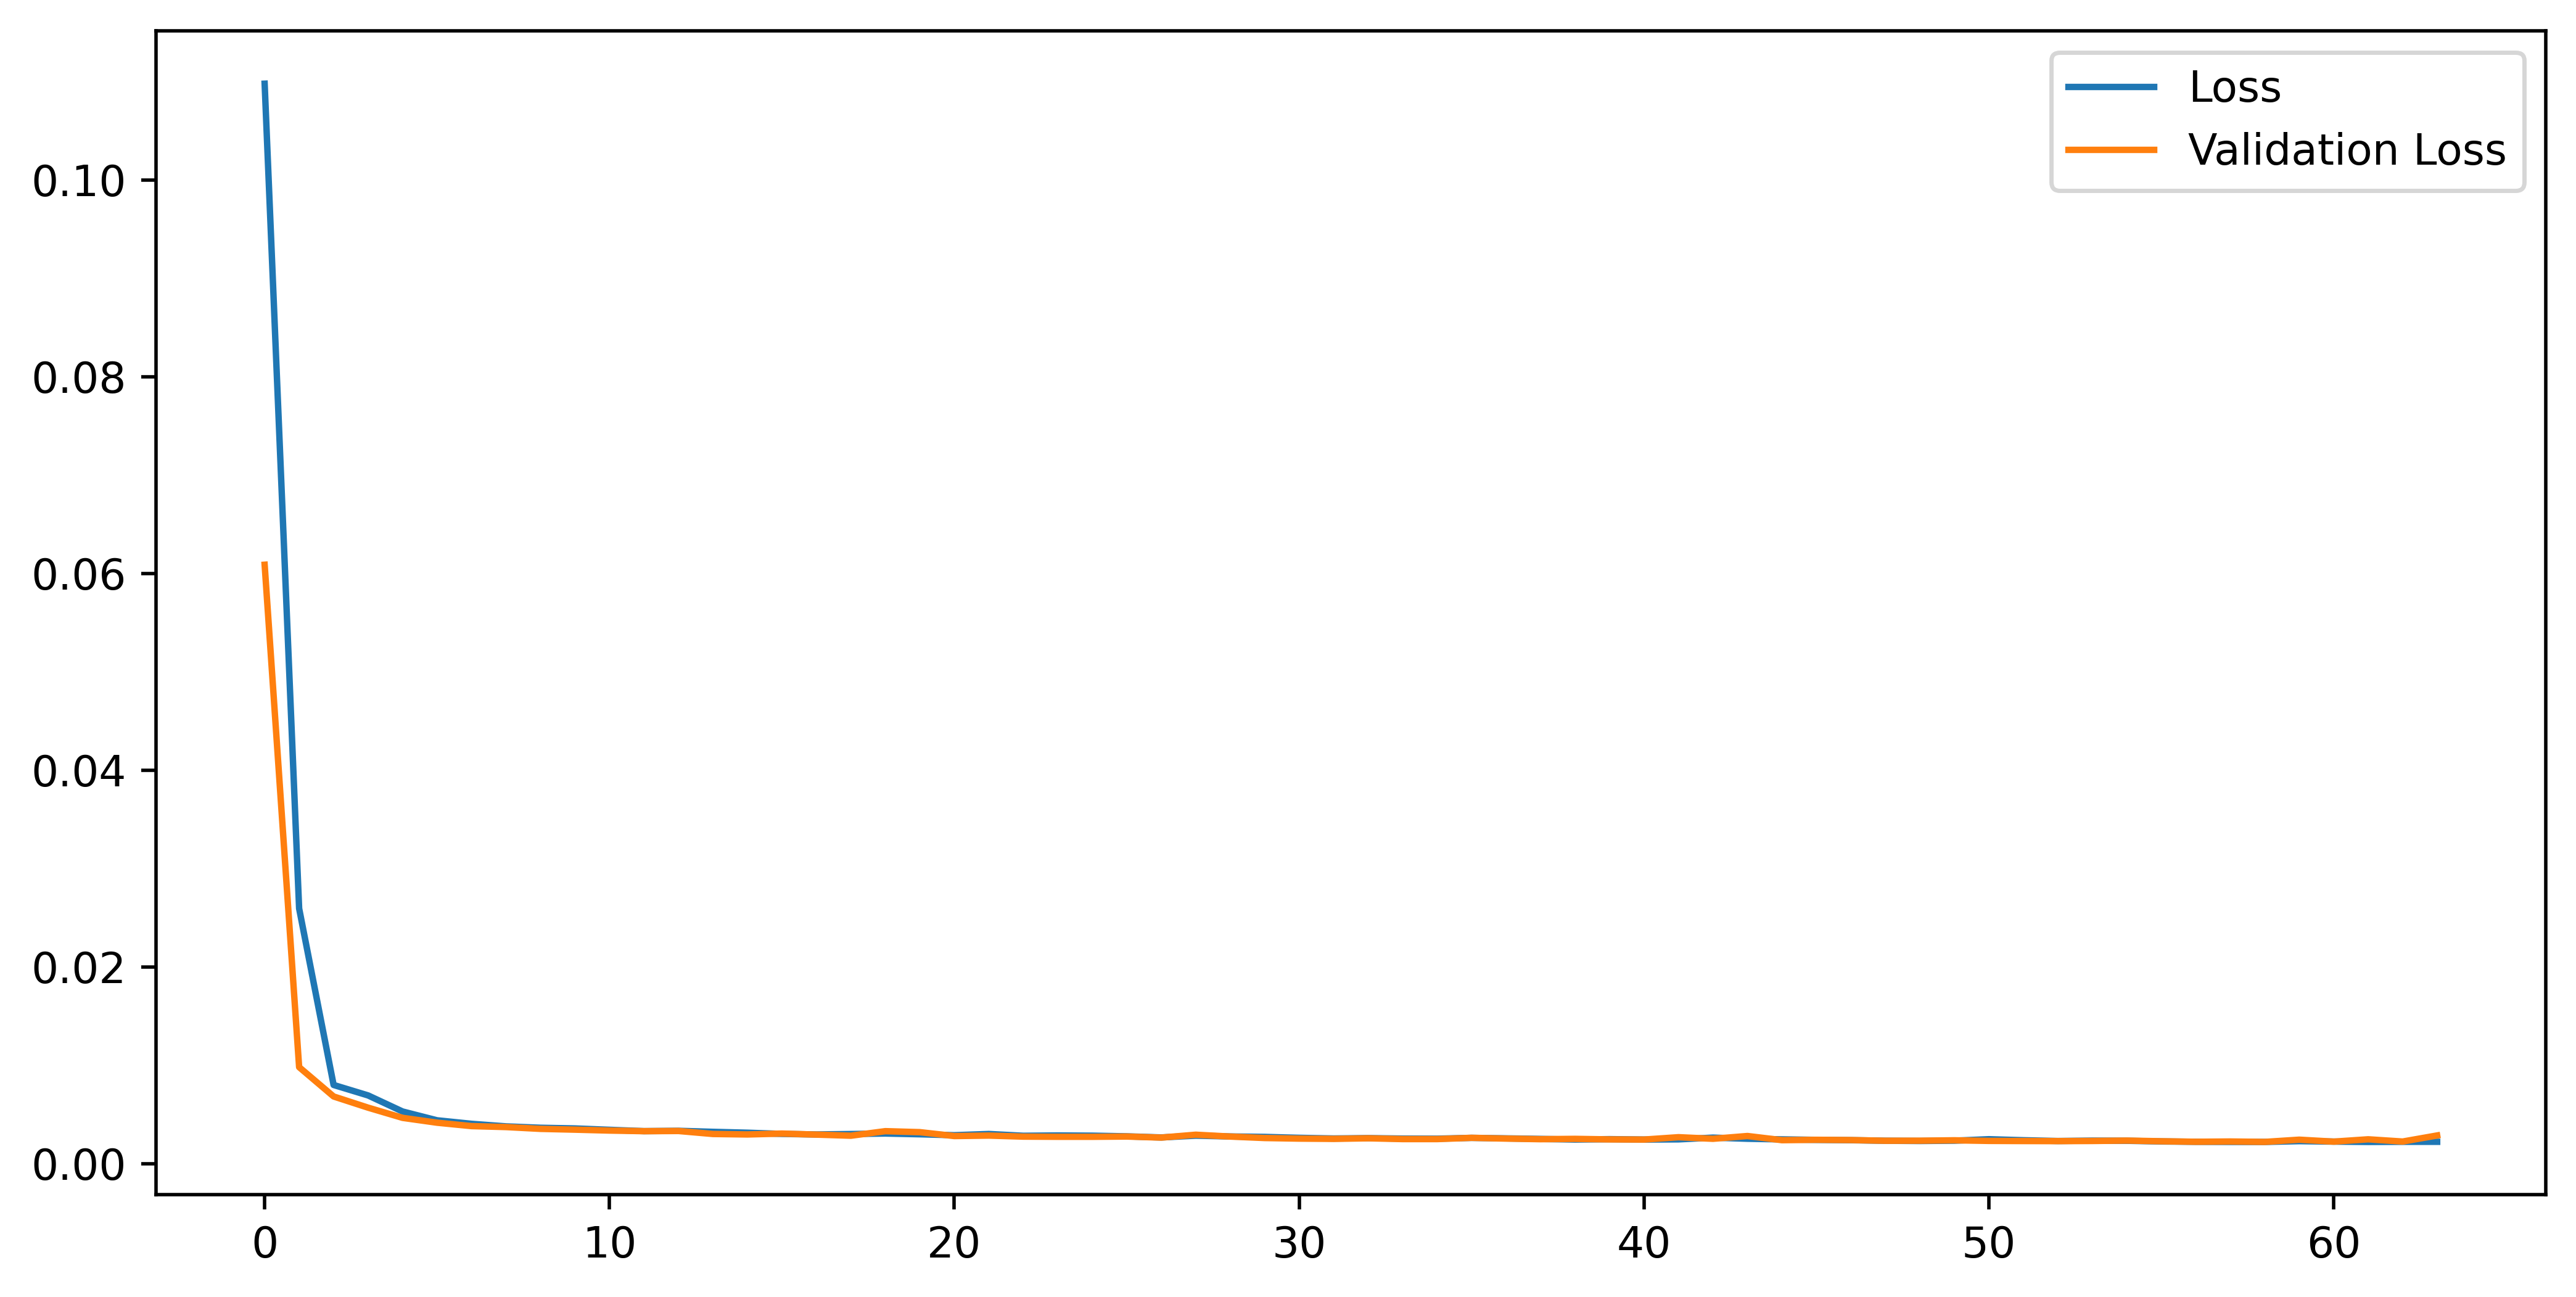

In [12]:
plt.figure(figsize=(10, 5), dpi=500)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss','Validation Loss'])

In [35]:
# decoder_net = Sequential(
# [
#     InputLayer(input_shape=(encoding_dimension,)),
#     Dense(np.prod(dense_dimension)),
#     Reshape(target_shape=dense_dimension),
#     Conv2DTranspose(256, 4, strides=2, padding="same", activation=tf.nn.relu),
# #     UpSampling2D((2, 2)),
#     Conv2DTranspose(128, 4, strides=2, padding="same",activation=tf.nn.relu),
# #     UpSampling2D((2, 2)),
#     Conv2DTranspose(64, 4, strides=2,  padding="same",activation=tf.nn.relu),
# #     UpSampling2D((2, 2)),
#     Conv2DTranspose(3, 3, strides=2, padding="same", activation='sigmoid')
# ])


# od = OutlierAE(threshold=0.001, 
#               encoder_net=encoder_net,
#               decoder_net=decoder_net)


# adam = Adam(lr=0.001)

# od.fit(X, epochs=50, verbose=True,
#       optimizer = adam)

InvalidArgumentError: Incompatible shapes: [64,128,128,3] vs. [64,256,256,3] [Op:SquaredDifference]

In [6]:
# decoder_net = Sequential(
# [
#     InputLayer(input_shape=(encoding_dimension,)),
#     Dense(np.prod(dense_dimension)),
#     Reshape(target_shape=dense_dimension),
#     Conv2D(512, 3, padding="same", activation=tf.nn.relu),
#     UpSampling2D((2,2)),
#     Conv2D(256,3, padding="same", activation=tf.nn.relu),
#     UpSampling2D((2,2)),
#     Conv2D(128, 3, padding="same", activation=tf.nn.relu),
#     UpSampling2D((2,2)),
#     Conv2D(3, 3, padding="same", activation='sigmoid')
# ])
# od = OutlierAE(threshold=0.10, 
#               encoder_net=encoder_net,
#               decoder_net=decoder_net)

# adam = Adam(lr=0.001)

# od.fit(data, epochs=200, verbose=True,
#       optimizer = adam)

InvalidArgumentError: Incompatible shapes: [64,64,64,3] vs. [64,128,128,3] [Op:SquaredDifference]

In [24]:
X[0].shape

(256, 256, 3)

In [ ]:
# encoding_dim = 1024
# dense_dim = [8, 8, 128]

# encoder_net = tf.keras.Sequential(
#   [
#       InputLayer(input_shape=X[0].shape),
#       Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
#       Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
#       Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
#       Flatten(),
#       Dense(encoding_dim,)
#   ])

# decoder_net = tf.keras.Sequential(
#   [
#       InputLayer(input_shape=(encoding_dim,)),
#       Dense(np.prod(dense_dim)),
#       Reshape(target_shape=dense_dim),
#       Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
#       Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
#       Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
#   ])


# od = OutlierAE(threshold=0.001, 
#               encoder_net=encoder_net,
#               decoder_net=decoder_net)


# adam = Adam(lr=0.001)

# od.fit(X, epochs=150, verbose=True,
#       optimizer = adam)

In [15]:
# od.infer_threshold(y_good, threshold_perc=95)

# preds_good = od.predict(y_good, outlier_type='instance',
#                   return_instance_score=True,
#                   return_feature_score=True)

# preds_bad = od.predict(y_bad, outlier_type='instance',
#                   return_instance_score=True,
#                   return_feature_score=True)

In [28]:
# len(preds_good['data']['feature_score'])

20

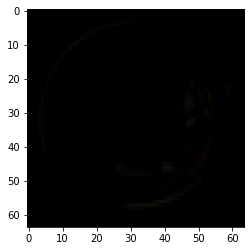

In [30]:
# plt.imshow(preds_bad['data']['feature_score'][0])

In [34]:
recon_good = od.ae(y_good).numpy()
recon_bad = od.ae(y_bad).numpy()

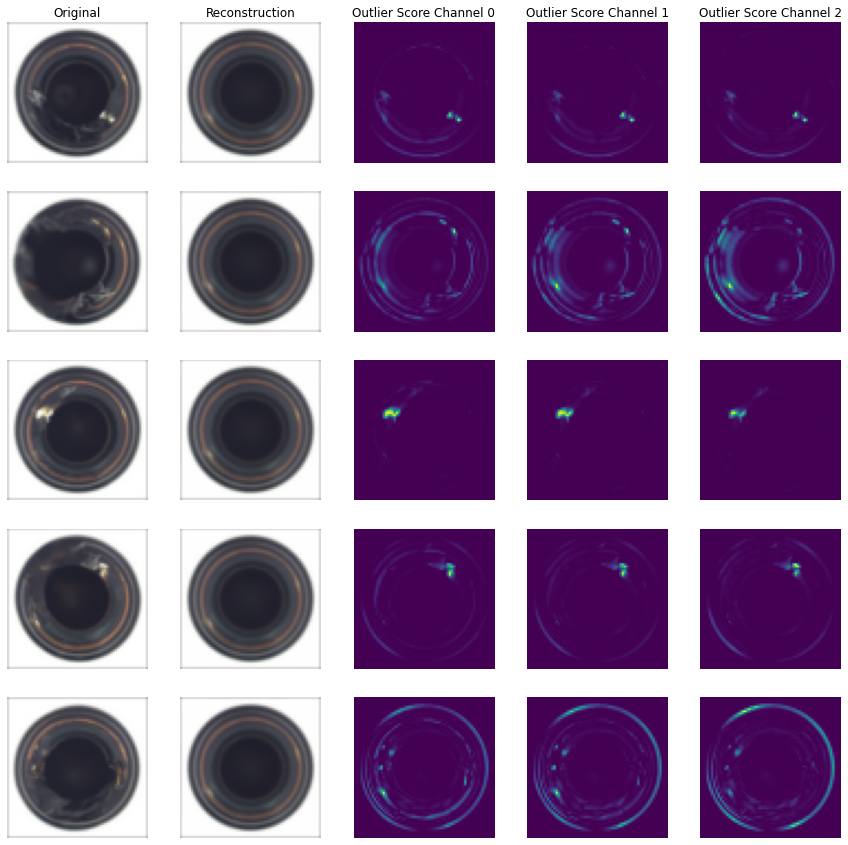

In [39]:
plot_feature_outlier_image(preds_bad, y_bad,
                          X_recon=recon_bad,
                          max_instances=5,
                          outliers_only=True,
                          figsize=(15,15))

## Visualizing differences using SSIM 

In [13]:
from skimage.measure import compare_ssim
from skimage.metrics import mean_squared_error

def generate_score_and_mask_ssim(original, reconstructed):
    original=np.mean(original, axis=-1)
    reconstructed = np.mean(reconstructed,axis=-1)

    (ssim_score, ssim_diff_img) = compare_ssim(original, reconstructed, full=True)
    return 1-ssim_score, 1-ssim_diff_img

def compare_img_and_masks(original, reconstructed, ssim_diff_image, true_mask = None):
    f = plt.figure(figsize=(15,15))

    ori = f.add_subplot(1,5,1)
    ori.set_title("Original")
#     original = original.squeeze()
    plt.imshow(original)

    recon = f.add_subplot(1,5,2)
    recon.set_title("Reconstructed")
#     reconstructed = reconstructed.squeeze()/
    plt.imshow(reconstructed)

    if true_mask is not None:
        t_mask = f.add_subplot(1,5,3)
        t_mask.set_title("Ground-truth Mask")
        plt.imshow(true_mask) 

    ssim_diff = f.add_subplot(1,5,4)
    ssim_diff.set_title("SSIM diff. image")
    plt.imshow(ssim_diff_image)
    

    plt.tight_layout()


# Jointly normalizes data1 and data2 to range of 0-1
def normalize(data1, data2):
    global_max = max(max(data1), max(data2))
    global_min = min(min(data1), min(data2))
    return (data1 - global_min) / (global_max - global_min), (data2 - global_min) / (global_max - global_min)


In [11]:
bad_scores = []

for i in range(len(y_bad)):
    original = y_bad[i]
    reconstructed = preds_ybad[i]
    
    ssim_score, ssim_diff = generate_score_and_mask_ssim(original,
                                                        reconstructed)
    bad_scores.append(ssim_score)
    
    compare_img_and_masks(original, reconstructed, ssim_diff, mask[i])

NameError: name 'preds_ybad' is not defined

In [15]:
good_scores = []

for i in range(len(y_good)):
    original = y_good[i]
    reconstructed = preds_ygood[i]
    
    ssim_score, ssim_diff = generate_score_and_mask_ssim(original,
                                                        reconstructed)
    good_scores.append(ssim_score)
    
#     compare_img_and_masks(original, reconstructed, ssim_diff, mask[i])

/home/sauraj/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


In [16]:
good_scores_norm, bad_scores_norm = normalize(good_scores, bad_scores)

In [17]:
#Threshold function for finding the optimal point after which images are considered outliers 
def num_errors(good_data, bad_data, t):
    false_positive = np.sum((good_data - t > 0)*1)
    false_negative =  np.sum((bad_data - t < 0)*1)
    return false_positive + false_negative


def best_threshold(good_data, bad_data):
    thresh = np.linspace(0.4,0,100)
    best_thresh = []
    min_error = float('inf')

    for t in thresh:
        error = num_errors(good_data, bad_data, t)
        if error < min_error:
            min_error = error

    for t in thresh:
        if num_errors(good_data, bad_data, t) == min_error:
            best_thresh.append(t)
  
    return np.mean(best_thresh)

In [18]:
#Get the threshold
ssim_thresh = best_threshold(good_scores_norm, bad_scores_norm)

In [1]:
ssim_thresh

NameError: name 'ssim_thresh' is not defined

In [20]:
from sklearn.metrics import f1_score

ssim_pred = np.concatenate(((good_scores_norm < ssim_thresh), (bad_scores_norm  < ssim_thresh))) * 1
ssim_true = np.concatenate((np.ones_like(good_scores_norm, dtype=int),np.zeros_like(bad_scores_norm, dtype=int)))

In [114]:
gg2 = np.concatenate((np.ones_like(good_scores_norm, dtype=int), 
                     np.zeros_like(bad_scores_norm, dtype=int)))

### Generating the F1-scores

In [9]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

print("SSIM F1-Score: {}".format(f1_score(ssim_true, ssim_pred)))
print("SSIM Precision Score: {}".format(precision_score(ssim_true, ssim_pred)))
print("SSIM Recall Score: {}".format(recall_score(ssim_true, ssim_pred)))
print("SSIM ROC-AUC Score: {}".format(roc_auc_score(ssim_true, ssim_pred)))

NameError: name 'ssim_true' is not defined

In [22]:
ssim_true

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        9232      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0     